# Introduction to the CT-INT solver

The continuous-time quantum Monte Carlo algorithm (CT-INT) allows to find a stochastic
solution for the Anderson impurity model

$$
\mathcal{H} = \epsilon_d \sum_\sigma d^\dagger_\sigma d_\sigma
+ U n_{d\uparrow} n_{d\downarrow}
+ \sum_{k \sigma} \epsilon_{k\sigma} c^\dagger_{k\sigma} c_{k\sigma}
+ \sum_{k \sigma} \left( V_{k \sigma} d^\dagger_{\sigma} c_{k\sigma} + \mathrm{h.c.} \right)
$$

The way the impurity is connected to the bath is encoded in the hybridization function

$$
\Delta_\sigma(i\omega_n) = \sum_k \frac{V_k^2}{i\omega_n - \epsilon_{k\sigma}}
$$

In this notebook, you will learn to use the CT-INT solver. Let us first import
some relevant general modules.

In [1]:
%matplotlib inline
import numpy as np
from triqs.gf import *
from triqs.plot.mpl_interface import *

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

## Constructing the CT-INT solver

Here we show how to construct an instance of a CT-INT solver.
First, we need to import two relevant modules. The first one
is an interface to the mpi and will initialize the mpi.
The second one is the CT-INT solver implemented in TRIQS.
Then, the solver is contructed from just two parameters:

- The inverse temperature `beta`
- The number of imaginary Matsubara frequencies `n_in` to be used

In [2]:
import triqs.utility.mpi as mpi
from triqs_ctint import Solver

# Parameters
beta = 20.0
n_iw = 200

S = Solver(beta, n_iw)

Starting run with 1 MPI rank(s) at : 2021-04-11 00:21:39.177885


## Solving the Anderson impurity model

In order to describe the structure of the Anderson impurity model,
a first step after the construction of the solver is to
initialize the member `G0_iw` of the solver instance. This
member is the non-interacting function of the model

$$
G_{0 \sigma} = \frac{1}{i\omega_n - \epsilon_d - \Delta_\sigma(i\omega_n)}
$$

After the non-interacting Green function is defined, the model
is solved by calling the `solve()` method with the following
arguments:

- The Coulomb interaction `U`
- The parameter `delta` that defines the value
  of the $\alpha$ shift and allows to have a better average sign
  
  $$
  \alpha_\sigma = \frac{1}{2} + (-1)^\sigma \delta
  $$
  
- The other parameters are related to the Monte Carlo
  - `length_cycle`: This is the number of steps between two measurements. This should
     be large enough to ensure data is decorrelated.
  - `n_warmup_cycles`: The number of cycles used to thermalize the system.
  - `n_cycles`: This is the number of Monte Carlo cycles, which is also the number of measurements
     of the Green's function.

The calculation will have a Markov chain of length `length_cycle` * (`n_warmup_cycles` + `n_cycles`).

Below is an example solving an impurity in a flat (Wilson) bath of half-bandwidth 2.

In [30]:
# Parameters
U = 1.0
delta = 0.1
n_cycles = 10**5
length_cycle = 50
n_warmup_cycles = 5000

# Energy level of the impurity level
eps_d = -U/2 - 0.5

# Initialize G0 and call solver
S.G0_iw << inverse(iOmega_n - eps_d - Wilson(2.0))
S.solve(U, delta, n_cycles, length_cycle, n_warmup_cycles)

## Outputs of the solver

After the solver is run, two members of the class are updated:
- `G_iw`: This is the interacting Green function of the problem in Matsubara frequencies
- `histogram`: A histogram showing how perturbation orders were visited

Text(0.5, 1.0, 'Interacting Green function')

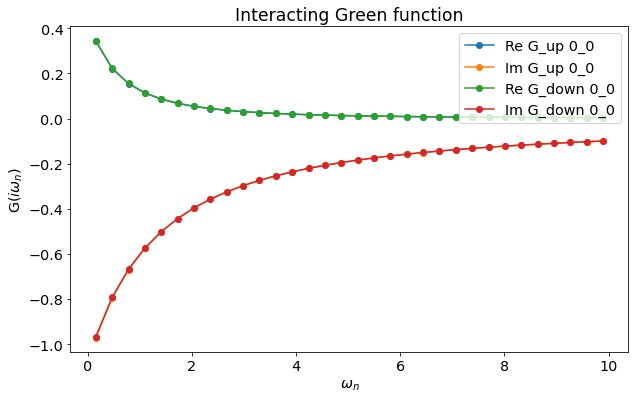

In [31]:
# Plot the Green function
oplot(S.G_iw, '-o', x_window=(0,10))
plt.title("Interacting Green function")

Average order =  1.82107


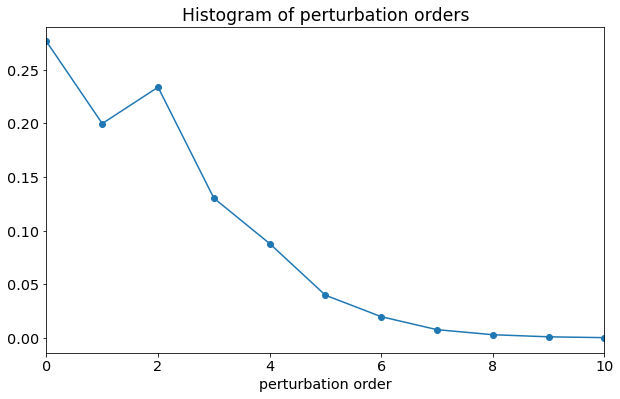

In [32]:
# Plot the histogram and compute the average histogram
hist = S.histogram
print("Average order = ", np.sum(np.arange(len(hist)) * hist))
plt.plot(hist, '-o')
plt.title("Histogram of perturbation orders")
plt.xlim(0,10)
plt.xlabel("perturbation order");

# Exercises

## Exercise 1: Perturbation order

Investigate how the perturbation order changes with $U$ and inverse temperature $\beta$.

In [35]:
# Loop over values of U
Ur = np.arange(1, 5)
average = np.zeros_like(Ur)
n_cycles = 10**4

for U in Ur:

    # Half-filling
    eps_d = -U/2

    # Initialize G0 and call solver
    S.G0_iw << inverse(iOmega_n - eps_d - Wilson(2.0))
    S.solve(U, delta, n_cycles, length_cycle, n_warmup_cycles)
    
    # Compute and print average perturbation order
    hist = S.histogram
    print("Average order for U = %.2f is %.2f"%(U, np.sum(np.arange(len(hist)) * hist)))

Average order for U = 1.00 is 1.10
Average order for U = 2.00 is 3.90
Average order for U = 3.00 is 8.02
Average order for U = 4.00 is nan


## Exercise 2: Green functions and self-energy

Compute the self-energy using Dyson's equation:

$$
\Sigma(i\omega_n) = G_{0\sigma}^{-1} - G_{\sigma}^{-1}
$$

Plot the self-energy for some of your calculations.

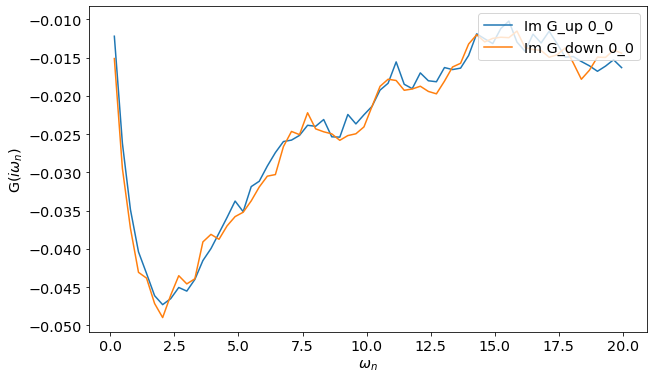

In [40]:
# Parameters
U = 1.0
delta = 0.1
n_cycles = 10**5
length_cycle = 50
n_warmup_cycles = 5000

# Energy level of the impurity level
eps_d = -U/2 - 0.5

# Initialize G0 and call solver
S.G0_iw << inverse(iOmega_n - eps_d - Wilson(2.0))
S.solve(U, delta, n_cycles, length_cycle, n_warmup_cycles)

Sigma = inverse(S.G0_iw) - inverse(S.G_iw)

oploti(Sigma, x_window=(0,20))

## Exercise 3: Monte Carlo noise

Increase and decrease the number of Monte Carlo cycles to see how its
effect on the quality of the self-energy.

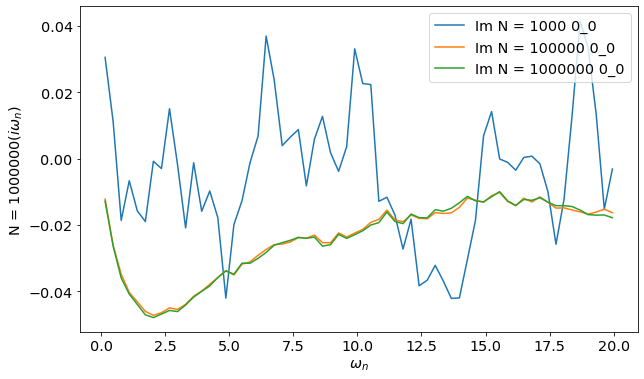

In [42]:
# Parameters
U = 1.0
delta = 0.1
length_cycle = 50
n_warmup_cycles = 5000

# Energy level of the impurity level
eps_d = -U/2 - 0.5

# Initialize G0 and call solver
S.G0_iw << inverse(iOmega_n - eps_d - Wilson(2.0))

for n_cycles in [10**3, 10**5, 10**6]:
    
    S.solve(U, delta, n_cycles, length_cycle, n_warmup_cycles)
    Sigma = inverse(S.G0_iw) - inverse(S.G_iw)
    oploti(Sigma['up'], name="N = %i"%n_cycles, x_window=(0,20))